# Aerial Cactus Identification

---

## Import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

## Dataset

In [2]:
train_path = '../data/train/'
test_path = '../data/test/'
train = pd.read_csv('../data/train.csv')
submission = pd.read_csv('../data/sample_submission.csv')

In [3]:
train

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1
...,...,...
17495,ffede47a74e47a5930f81c0b6896479e.jpg,0
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,0


In [4]:
train['has_cactus'] = train['has_cactus'].astype(str)

(32, 32, 3)


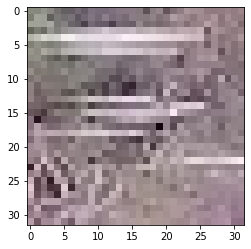

In [5]:
img = load_img(train_path+'0004be2cfeaba1c0361d39e2b000257b.jpg')
plt.imshow(img)
img_array = img_to_array(img)
print(img_array.shape)

## Preprocess

In [6]:
datagen = ImageDataGenerator(rescale = 1/255.0,
                            rotation_range=30,
                            width_shift_range=0.3,
                            height_shift_range=0.3,
                            shear_range=0.3,
                            zoom_range=0.3,
                            fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [7]:
valid_generator = datagen.flow_from_dataframe(dataframe=train[:3500],
                                             directory=train_path,
                                             x_col='id',
                                             y_col='has_cactus',
                                             class_mode='binary',
                                             batch_size=32,
                                             target_size=(32,32),
                                             Shuffle=True,
                                             seed=2020)

Found 3500 validated image filenames belonging to 2 classes.


In [8]:
train_generator = datagen.flow_from_dataframe(dataframe=train[3500:],
                                             directory=train_path,
                                             x_col='id',
                                             y_col='has_cactus',
                                             class_mode='binary',
                                             batch_size=32,
                                             target_size=(32,32),
                                             Shuffle=True,
                                             seed=2020)

Found 14000 validated image filenames belonging to 2 classes.


## Model

In [25]:
input_ = tf.keras.layers.Input(shape=(32,32,3))

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(input_)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2,2), strides=(2,2))(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2,2), strides=(2,2))(x)

x = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2,2), strides=(2,2))(x)

x = tf.keras.layers.GlobalAvgPool2D()(x)
x = tf.keras.layers.Dense(4096, activation='relu')(x)

output_ = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [26]:
model = tf.keras.models.Model(input_, output_)

In [27]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 128)         0   

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr= 0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              metrics=['accuracy'])

In [29]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.7, patience=30)

In [30]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model.h5",
                                                  save_best_only=True,
                                                  monitor='val_accuracy',
                                                  mode='auto')

## Train

In [31]:
epochs=100

In [32]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=epochs,
                              validation_data = valid_generator,
                              validation_steps=50,
                             callbacks=[lr_scheduler, checkpoint_cb])

Epoch 1/100
100/100 [==============================] - 3s 25ms/step - loss: 0.5334 - accuracy: 0.7506 - val_loss: 0.6264 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 2s 24ms/step - loss: 0.5662 - accuracy: 0.7475 - val_loss: 0.5691 - val_accuracy: 0.7462 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 2s 24ms/step - loss: 0.5396 - accuracy: 0.7650 - val_loss: 0.5715 - val_accuracy: 0.7468 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 2s 23ms/step - loss: 0.5613 - accuracy: 0.7481 - val_loss: 0.5721 - val_accuracy: 0.7412 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 2s 25ms/step - loss: 0.5313 - accuracy: 0.7550 - val_loss: 0.4170 - val_accuracy: 0.8731 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 2s 23ms/step - loss: 0.4361 - accuracy: 0.8003 - val_loss: 0.5688 - val_accuracy: 0.7354 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 2s 

Epoch 53/100
100/100 [==============================] - 2s 23ms/step - loss: 0.1242 - accuracy: 0.9494 - val_loss: 0.0903 - val_accuracy: 0.9595 - lr: 0.0010
Epoch 54/100
100/100 [==============================] - 2s 23ms/step - loss: 0.1017 - accuracy: 0.9604 - val_loss: 0.1587 - val_accuracy: 0.9381 - lr: 0.0010
Epoch 55/100
100/100 [==============================] - 2s 24ms/step - loss: 0.0960 - accuracy: 0.9641 - val_loss: 0.1249 - val_accuracy: 0.9487 - lr: 0.0010
Epoch 56/100
100/100 [==============================] - 2s 23ms/step - loss: 0.0852 - accuracy: 0.9650 - val_loss: 0.0983 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 57/100
100/100 [==============================] - 2s 24ms/step - loss: 0.1118 - accuracy: 0.9569 - val_loss: 0.1868 - val_accuracy: 0.9247 - lr: 0.0010
Epoch 58/100
100/100 [==============================] - 2s 24ms/step - loss: 0.1015 - accuracy: 0.9625 - val_loss: 0.0881 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 59/100
100/100 [==============================

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Loss')

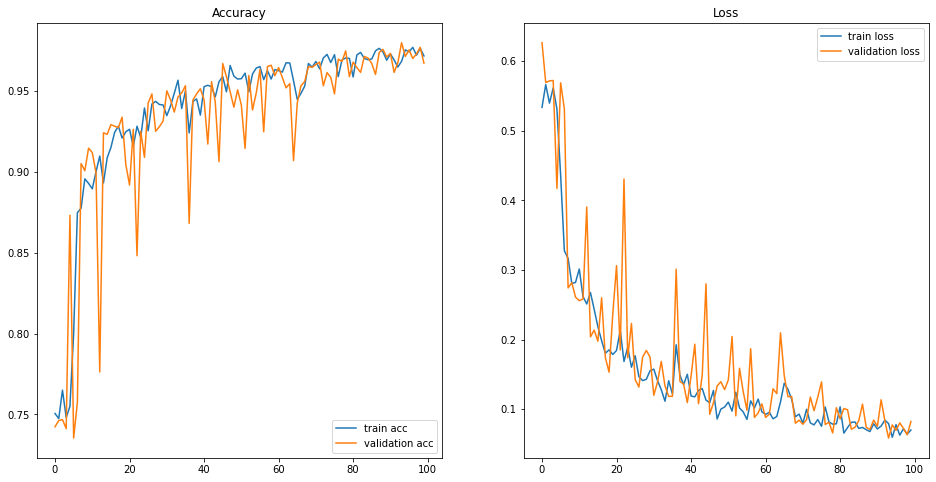

In [34]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), acc, label='train acc')
plt.plot(range(epochs), val_acc, label='validation acc')
plt.legend(loc='lower right')
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(range(epochs), loss, label='train loss')
plt.plot(range(epochs), val_loss, label='validation loss')
plt.legend(loc='upper right')
plt.title("Loss")

## Prediction

In [35]:
best_model = tf.keras.models.load_model('model.h5')

In [37]:
tests = pd.DataFrame()
tests['id']= os.listdir(test_path)

In [38]:
tests

,id
0,90215d80d9af4c751646015aabf33660.jpg
1,5ffc4f64d6f73f85c484596de8f68e1d.jpg
2,c3d1d83d50483e6e97b7290fa2db51ac.jpg
3,bee03b86bb300e81a3b4480d1a35e801.jpg
4,8f7c18b70b979a25e7f09e108188202c.jpg
...,...
3995,6054b22afc730171f4c7eaddaefa18ae.jpg
3996,5b0ddc8fd679ecbec4f9c7461dae6ffe.jpg
3997,05738a763b54b164019a62be99739702.jpg
3998,132e8c9df799f34740bfc2f8845a3910.jpg


In [39]:
test_gen = test_datagen.flow_from_dataframe(dataframe=tests,
                                             directory=test_path,
                                             x_col='id',
                                             y_col=None,
                                             class_mode=None,
                                             batch_size=32,
                                             target_size=(32,32),
                                             Shuffle=False,
                                             seed=2020)


Found 4000 validated image filenames.


In [41]:
test_gen.n

4000

In [42]:
pred = best_model.predict_generator(test_gen, steps=test_gen.n//test_gen.batch_size, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
125/125 [==============================] - 1s 5ms/step


In [43]:
pred

array([[0.99995816],
       [0.7687816 ],
       [0.98841685],
       ...,
       [0.99746656],
       [0.02626724],
       [0.9999999 ]], dtype=float32)

In [44]:
tests['has_cactus'] = pred

In [45]:
tests

,id,has_cactus
0,90215d80d9af4c751646015aabf33660.jpg,0.999958
1,5ffc4f64d6f73f85c484596de8f68e1d.jpg,0.768782
2,c3d1d83d50483e6e97b7290fa2db51ac.jpg,0.988417
3,bee03b86bb300e81a3b4480d1a35e801.jpg,0.998545
4,8f7c18b70b979a25e7f09e108188202c.jpg,1.000000
...,...,...
3995,6054b22afc730171f4c7eaddaefa18ae.jpg,1.000000
3996,5b0ddc8fd679ecbec4f9c7461dae6ffe.jpg,1.000000
3997,05738a763b54b164019a62be99739702.jpg,0.997467
3998,132e8c9df799f34740bfc2f8845a3910.jpg,0.026267


In [46]:
tests.to_csv('tests.csv', index=False)